# Applied AI for Health Research
# Practical 1



In [1]:
#
# I modified this
#
running_on_colab = False
#
if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# Lecture 1: The inner workings of neural networks

## The relationship between artifical and biological neurons

The basic biological unit of brain computation is a neuronal cell (see figure below). Each cell is essentially an electrical device that receives signals at the dendrites (surrounding the cell body) and, once these exceed a threshold, transmits the signal down the cell axon to synaptic terminals, where it then connects with other cells.

<img src="https://drive.google.com/uc?id=1i3nntiP9pWUCyFNfZGPL-Rvg-8EYXftg" alt="Drawing" style="width: 800px;"/>

Artificial neurons are designed to mimic this process, but only in a limited or constrained way. The idea is that the modulatory effect of the different synaptic connections is modelled through linear multiplication  of input signals $x_i$ with weights $w_i$, plus a bias term which shifts the centre of the prediction from zero. If the final sum is high enough, modelled through an nonlinear activation function $f$, the artificial neuron is allowed to ‘fire’ in response to that pattern of activation. 

Then, the optimisation process of neural networks involves learning optimal weights and biases to perform a given task. 

Note, while it can be useful to explain how the design of artifical neurons was motivated by the concept of biological networks, they remain far from a close simulation of the true thing. In truth design of many components of the most common artificial networks used for computer vision today are more inspired by engineering choices than any true goal to replicate human brain function. Biologically inspired neural networks  exist but, to an extent, they are a are a separate and  distinct line of research.

For more details, and the source which inspired the neuron diagram, see the explanation from [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/neural-networks-1/)

## A Single Neuron Logistic Regression Classifier

To understand how neural networks work, it serves to consider a single neuron as a logistic regression classifier:

<img src="https://drive.google.com/uc?id=1bz_hR949l986NLChyme1tlD4gyg1VoF4" alt="Drawing" style="width: 800px;"/>

Here the line $z =0$ defines a separating hyperplane, where the bias term $w_0$ has shifted this from the origin, and all data points with $z >0$ are assigned to the positive class, and all data points with $z < 0$ are assigned the negative class.

The vector $\mathbf{W}$ runs perpendicular to the line $z =0$ and defines the direction in which data classes are maximally separated when projected onto it. 


<img src="https://drive.google.com/uc?id=1PX-napPbTEAVAhe2zwoukRNbjoAZbk4p" alt="Drawing" style="width: 100px;"/>

## Exercise 1: Implementing a single neuron classifier through logistic regression

In this section we will train a classifier to predict if a neonate is preterm based on volume measures of 86 brain volumes. We will code up and train a logistic regression classifier from scratch.

### Import the data
The data are in the file "prem_vs_termwrois.pkl". The final column indicates whether each data set was collected from a term or preterm baby (scanned at term equivalent age). The data represent mean vales of three different types of cortical imaging data: cortical thickness, cortical folding and cortical myelination, all averaged within 100 regions of interest ROIS on the surface. This gives 300 features in total. 

<img src="https://drive.google.com/uc?id=1ZbAn0R_ihQ4DCe1XyKaHIRZSvUQv3puh" alt="Drawing" style="width: 800px;"/>

There are 101 babies, 50 terms and 51 preterms. The code below loads the file and splits the data randomly into a train and test set. The data is transposed such that the rows reflect features and the columns examples (as expected from the lectures notation). A row of ones is added to each dataset to allow model;ling of the bias term.

**To Do** upload the data file to your local Google Drive, update the ```file_path``` accordingly and run the below code cell.

**Be sure to understand what each line is doing.**

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# STUDENTS CODE HERE - UPDATE THE PATH TO CORRESPOND TO WHERE YOU HAVE UPLOADED prem_vs_termwrois.pkl TO YOUR DRIVE #
if running_on_colab:
    file_path = '/content/drive/My Drive/Colab Notebooks/AdvancedML/2021/01_fundamentals/prem_vs_termwrois.pkl'
else:
    file_path = "prem_vs_termwrois.pkl"
#
# Read the data
df = pd.read_pickle(file_path)
data = df.values[:,:-2]
y = df.values[:,-1]

# create a test and train split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=42)

# Create feature matrix
X_train = X_train.T
X_test=X_test.T

#reshape y to (1 x n_T) matrix
y_train=np.expand_dims(y_train, axis=0)
y_test=np.expand_dims(y_test, axis=0)


# add a row of ones for multiplication with bias term
X_train = np.concatenate((np.ones((1,X_train.shape[1])),X_train))
X_test = np.concatenate((np.ones((1,X_test.shape[1])),X_test))

# set variables for numbers of feature and examples to improve readabiity of code
n_features=X_train.shape[0]-1
n_examples=X_train.shape[1]

print('Dimension of X is ', X_train.shape,data.shape)
print('Dimension of y is ', y_train.shape)

print('Number of features', n_features)
print('Number of examples', n_examples)

Dimension of X is  (301, 90) (101, 300)
Dimension of y is  (1, 90)
Number of features 300
Number of examples 90


In [7]:
#
# I put this cell in so I could see the data
#
# NB: Need to be a bit careful here since raw data has not been transposed to [p, n]
#
df.to_csv("prem_vs_termwrois.csv")

In [8]:
#
# I put this cell in
#
X_train.shape
#
# So it comes out as 301, 90 which is [p, n]
#

(301, 90)

### Eyeball the data
The following code plots histograms of a single feature (brain volume) for preterms vs terms. Run the code for a few different values of 'feature'.

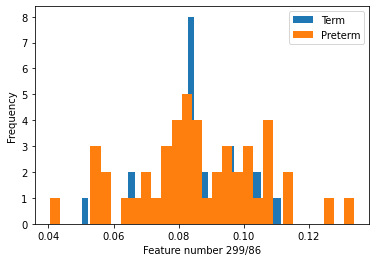

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

#### STUDENT'S CODE HERE ####
# try values between 0 and 300
#feature = 150
feature = 299

plt.hist(X_train[feature+1, y_train[0]==0], bins=30)
plt.hist(X_train[feature+1, y_train[0]==1], bins=30)
plt.xlabel('Feature number {}/86'.format(feature))
plt.ylabel('Frequency')
plt.legend(['Term','Preterm']);

### Model

Our predictions for a single logistric regression classifier may be written:
$$ f= f(z) = \dfrac{1}{1+e^{-z}} $$

Where, for $f$ is the sigmoid function and $$z$$ is the linear transform of $\mathbf{x}$ by $\mathbf{w}$:

$$z=w_0 + w_1x_1 + w_2x_2 +w_3x_3....+w_m x_m$$

Here $w_0$ is the bias term, $w_1,w_2....w_m$ are the weights;, $m$ is the number of features and $\mathbf{x}$ is a single example (i.e. one column) from our training set $X \in \mathbb{R}^{m\times n}$ .

### Implementation of the forward pass

We could calculate $f$ in one line of code, but it will come in handy when considering backpropagation later to consider the computation in stages, with each stage consisting of a simple module:

$$
\begin{align} 
\mathbf{Z} &= \mathbf{W} \mathbf{X} \\
\mathbf{F}=f(\mathbf{Z}) &= \dfrac{1}{1+e^{-\mathbf{Z}}} 
\end{align}
$$

Implemented using vectorisation. 



### Task 1.1 Initialise $\mathbf{W}$

**To do** Create a matrix of zeros to initialise $\mathbf{W}$ (note initialisation by zero is ok for a single neuron). 

- If $\mathbf{X}$ has shape $(m_{features} \times n_{examples})$, and we know that $\mathbf{Z}$ (and thus $\mathbf{F}$) should return _one_ scalar prediction _per example_, what shape should $\mathbf{W}$ be? 

In [8]:
#### STUDENT'S CODE HERE ####
#
# Both work, I suppose the vector version is a bit cleaner - i.e. its a column vector
# whereas [1, 301] is more accurate in principal and creates a row vector (i.e. 1 row many columns)
#
#W = np.zeros([1, 301], dtype=float)
W = np.zeros(301, dtype=float)
# Answer:
print(W.shape)

(301,)


In [17]:
#
# I'm just making it a bit more interesting with non-zero weights
#
W = np.random.rand(301) - 0.5
print(W)

[-1.45318122e-01  4.42462664e-01 -2.44283383e-01 -2.65698001e-01
 -2.57126901e-01 -3.44011537e-01  8.29151686e-03  3.04658973e-01
 -2.87009817e-01  4.52241573e-01 -4.17763347e-01 -3.35829910e-02
  6.54160177e-02  2.35284320e-01  3.10059555e-01 -4.95418097e-02
 -1.75625986e-01 -2.57206664e-01 -2.65487306e-01  2.77631188e-01
  1.31958482e-02  2.69302673e-01  6.01958106e-02 -3.41887973e-01
  1.92822069e-01 -7.96566821e-02 -7.05670176e-02  5.84003259e-02
  1.89484943e-01  3.82645344e-01  2.83112874e-01 -3.28666262e-01
 -3.34172971e-01  2.23095538e-02 -3.70338340e-01  4.86441639e-01
 -4.82935834e-01  8.35553935e-03  1.80871372e-01 -4.90956315e-01
  2.01072502e-01  3.82456602e-02  4.26645495e-01  4.43930498e-01
 -7.32963877e-02  4.45960281e-01 -2.93106876e-01 -1.30445575e-01
  1.21617148e-01 -1.56332285e-01 -6.62325273e-02  4.30661680e-01
 -8.01745630e-03 -3.70657567e-01  4.41389654e-02  3.05838684e-01
 -1.35453517e-04 -3.06295726e-01 -1.97559850e-01 -2.68453690e-01
  7.27505548e-02  1.88202

### Task 1.2 Estimate $\mathbf{Z}$: 

**To do** Write a function $z(w,x)$ that uses vectorisation to linearly transform data matrix $\mathbf{X}$ using the weights matrix $\mathbf{W}$.

**Hint** implement $\mathbf{Z} = \mathbf{W} \mathbf{X}$; print out the shape - is it what you would expect?


In [19]:
# task 1.2 complete function to calculate Z (can be done in one line in the return statement)
def z(w,x):
    #### STUDENT'S CODE HERE ####
    return np.matmul(w, x)

Z = z(W,X_train)
print(Z.shape)

(90,)


### Task 1.3 Implement Sigmoid function f: 

**To do** Now write a function to compute $f(\mathbf{Z})=\dfrac{1}{1+e^{-\mathbf{Z}}} $, our logistic regression function:

**Hint** don't forget to implement with numpy functions - to support vectorisation

In [26]:
#
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))
#
print(sigmoid(Z))

[0.08308693 0.07902029 0.10193474 0.07863095 0.08823107 0.07440353
 0.15361047 0.09768775 0.0927298  0.12646898 0.129329   0.16020196
 0.1320178  0.12446809 0.07905117 0.08344038 0.1082308  0.09059476
 0.09573213 0.10990414 0.12086946 0.08952739 0.0692495  0.08357295
 0.07381796 0.12946158 0.12628266 0.11815829 0.10094735 0.09803785
 0.10991909 0.12360761 0.04733751 0.10994599 0.08816454 0.14016862
 0.08792181 0.05296529 0.12437959 0.09123498 0.14383051 0.12178138
 0.06643256 0.0811126  0.11108567 0.06086472 0.07254336 0.12315793
 0.08841809 0.0731495  0.11069117 0.08618878 0.11887805 0.08222868
 0.0972968  0.10436327 0.09005629 0.05917612 0.14301112 0.13289479
 0.08641858 0.10688128 0.07060787 0.08203876 0.07345461 0.14922311
 0.07100118 0.11790478 0.07793559 0.09000051 0.11111214 0.14239484
 0.11015949 0.14142798 0.10454557 0.11202916 0.08677183 0.03256962
 0.09105923 0.11208129 0.10151022 0.04834533 0.11406087 0.13193918
 0.09029769 0.12121154 0.09880953 0.07572543 0.08323477 0.0849

In [28]:
# task 1.3 implement sigmoid function with vectorisation (in one line in the return statement)
def f(z):
  #### STUDENT'S CODE HERE ####
    return 1 / (1 + np.exp(-z))

**To do** Verify your softmax looks right by running this plotting code:

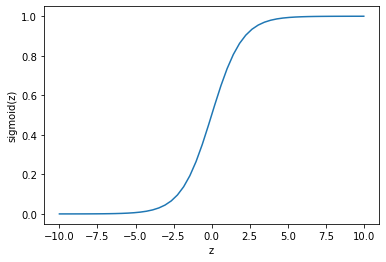

In [29]:
inputs = np.linspace(-10,10)
outputs = f(inputs)
plt.plot(inputs, outputs)
plt.xlabel('z')
plt.ylabel('sigmoid(z)');

We're now in a position to compute some predictions $\mathbf{\hat{y}}$ (**run below code cells**):

In [30]:
y_pred = f(z(W,X_train))

**To do** Are these predictions any good? Let's take a look at the accuracy (run below cell):

In [31]:
def accuracy(y, y_pred, threshold = 0.5):
    y_pred_thresholded = y_pred > threshold
    correct_predictions = np.sum(y==y_pred_thresholded) 
    total_predictions = y.shape[1]
    accuracy = 100 * correct_predictions / total_predictions
    return accuracy

In [32]:
y_pred = f(z(W, X_train))
print(accuracy(y_train, y_pred))

47.77777777777778


Look at the predictions ```y_pred```, what does this initial prediction return and why? **Enter your answer in the box below**

**Answer:**

### Task 1.4 Implement Cross Entropy Loss:

Accuracy is easy to intepret, but can't be optimised using gradient descent. We need a measure of our prediction quality that can be. A typical loss function used in  classification problems is cross-entropy:

$$L(y_i,f(z_i)) = - y_i \ln(f(z_i)) - (1-y_i) \ln(1-f(z_i))$$

This may be implemented using vectorisation as:

$$L(\mathbf{Y},\mathbf{F}) = - \mathbf{Y} \ln(\mathbf{F} + \epsilon) - (1-\mathbf{Y}) \ln(1-\mathbf{F} + \epsilon)$$

This returns a vector of losses $(L_1,L_2....L_n)$ estimated for all training examples n. The $\epsilon$ is added for numerical stability. We require the total cost estimated as:

$$ J(\mathbf{W})= \frac{1}{n} \sum_i L_i(y_i,f(z_i)) $$

**To do Implement the Cross-Entropy loss and return the total cost**

**hint** using numpy functions for vectorisation. 

In [ ]:
# task 1.4 implement loss function to calculate cross-entropy loss for all examples and average to return total cost
# note the negative sign so that the loss decreases as our predictions get better
def loss(y, y_pred):
    epsilon = 1e-5
    #### STUDENT'S CODE HERE - replace Nones - ####
    # note, we must add a small penalty term (epsilon) to prevent calculation of log(0)
    L = None
    J = None 
    return J

In [ ]:
total_loss= loss(y_train,y_pred)
print(total_loss)

## The Computation Graph

Now we have our functions for $\mathbf{L}$ and $\mathbf{Z}$, and initialised $\mathbf{W}$, we are finally in a position to compute a forward and backward pass. Computation graphs can help us to this by tracking the order of operations. The computation graph for logistic regression is:

<img src="https://drive.google.com/uc?id=1tWrFwh_lT_RVfYmodkvR_uRP8JOGfOu0" alt="Drawing" style="width: 800px;"/>

We can estimate the backwards pass using the chain rule:

> > > > > >  <img src="https://drive.google.com/uc?id=14tKMEhXhlP2psxfdxrNWTt8M-LcfZL9m" alt="Drawing" style="width: 100px;"/>

Working backwards from the right side, this determines that to calculate the gradient of the loss with respect to the parameters we need;

<img src="https://drive.google.com/uc?id=1R3qEtBPHZCwJ_e3uWwWoO5vx050vjGgg" alt="Drawing" style="width: 800px;"/>

And don't forget that the full cost equates to the mean of the loss over all examples $J=\frac{1}{n_T}\sum_i L_I$ , $\dfrac{dJ}{dW}=\frac{1}{n_T} \sum_i \dfrac{dL_i}{dW} $ . All calculations should be vectorised. 

### Task 1.5 Implement Forward Pass


We now have all the components of the forward pass for our logistic regression. Write a full forward pass that takes data, targets and a weight matrix and performs the forward pass, with vectorisation calculating the loss:

In [ ]:
# task 1.5 implement the forwards pass to calculate F and then print loss and accuracy
def forward_pass(X, y, W):
    #### STUDENT'S CODE HERE - replace Nones to calculate F (loss and accruacy is printed for you) - ####
    F = None
    print('Loss: {}'.format(loss(y,y_pred)))
    print('Accuracy: {}'.format(accuracy(y,y_pred)))

In [ ]:
#perform forward pass
forward_pass(X_train,y_train, W)

### Task 1.6 Implement backwards pass

We're now ready to try and adjust our parameters $\mathbf{W}$ in order to optimise our predictions. To do this we need to calculate the change in our loss function with respect to our parameters, $\dfrac{\partial L}{\partial \mathbf{W}}$. 

Recalling our staged calculation of the logistic regression (in vectorised form):

$$
\mathbf{Z} = \mathbf{W} \mathbf{X} \\
\mathbf{F}= \dfrac{1}{1+e^{- \mathbf{Z}}} \\
\mathbf{L}  =  - \mathbf{Y} \ln(\mathbf{F}) - (1-\mathbf{Y}) \ln(1-\mathbf{F})
$$

We can write the vectorised gradients for each individual stage (see lecture slides and keats quiz): 

$$
\dfrac{\partial L}{\partial f} = \dfrac{\mathbf{F} - \mathbf{Y}}{\mathbf{F}(1-\mathbf{F})}\\
\dfrac{\partial f}{\partial z} = \mathbf{F}(1-\mathbf{F}) \\
\dfrac{\partial z}{\partial w} = \mathbf{X}^T
$$

And compose through the chain rule:

$$ 
\dfrac{\partial L}{\partial w} = \dfrac{\partial L}{\partial f} \cdot \dfrac{\partial f}{\partial z} \cdot\dfrac{\partial z}{\partial w} \\
\dfrac{\partial L}{\partial w} = \dfrac{\mathbf{F} - \mathbf{Y}}{\mathbf{F}(1-\mathbf{F})} \cdot \mathbf{F}(1-\mathbf{F}) \cdot \mathbf{X}^T
$$

Which can be simplified by cancelling $ \mathbf{F}(1-\mathbf{F})$ terms in both the numerator and the denominator: 

$$ \dfrac{\partial L}{\partial w} = (\mathbf{F} - \mathbf{Y}) \mathbf{X}^T $$

Let's calculate the gradient of our loss, $\dfrac{\partial L}{\partial \mathbf{W}}$, for a **single** input, $\mathbf{x}$. 

**To do** Fill in the calculations of the backward pass in the following code:

In [ ]:
W = np.zeros((1,X_train.shape[0]))

# select just the first example here
x = X_train[:,0]
y_single = y[0]
print('The true value of y is: {}'.format(y_single))

# calculate the forward pass, and store the outputs at each stage
Z = z(W,x)
F = f(Z)
print('Our prediction for y is: {}'.format(F))

l = loss(y_single,F)
print('The loss is {}'.format(l))

#### STUDENT'S CODE HERE - replace Nones - ####
# now enter the backwards pass here, 
#implementing using the equations above:
dl_dw = None

print(dl_dw.shape,W.shape,x.shape)

**To do - run below code cells to check your implementation** 

We can check this gradient calculation is correct by updating our weights vector and looking at our new prediction:

In [ ]:
# The gradient is in the direction of increasing loss,
# so we subtract the gradient from w.
W = W - 0.001 * dl_dw
Z = z(W,x)
F = f(Z)
l = loss(y_single,F)
print('Our updated prediction for y is: {}'.format(F))
print('The loss is {}'.format(l))

Looks good! We have only updated $\mathbf{w}$ using information from a single data point. In practice we want to use all the data available. The following implements the gradient calculation for all data points, using vectorisation. Make sure you understand what is happening here:

In [ ]:
w = np.zeros((1,X_train.shape[0]))

# calculate the forward pass, and store the outputs at each stage
Z = z(w,X_train)
F = f(Z)
l = loss(y_train, F)

# To do - implement the backward pass
dL_dw = np.matmul((F-y_train),X_train.T) 

print('dL_dw has shape: {}'.format(dL_dw.shape))

grad_mean = dL_dw/n_examples

### Task 1.7 -  Putting it all together: the training loop

We now have everything we need to train a logistic regression classifier using backprop.

**To do** Fill out the training loop below referencing the code you have already written (or been given) in this notebook.

In [ ]:
# initialise w to all zeros
w = np.zeros((1,X_train.shape[0]))
epsilon=1e-5
# Normalise the data matrix (Ignoring the first row of ones which correspond to the bias term and is therefore all ones)
X_norm = np.ones_like(X_train)
X_norm[1:] = (X_train[1:] -X_train[1:].min(axis=1,keepdims=True) )/ (X_train[1:].max(axis=1,keepdims=True)-X_train[1:].min(axis=1,keepdims=True)+epsilon)
# we'll store the loss and accuracy in these lists during training
loss_record = []
accuracy_record = []

num_iterations = 5000
learning_rate = 1e-4

for i in range(num_iterations):
    # forward pass - get predictions
    #### STUDENT CODE HERE -replace nones ####
    # answer
    Z = None
    F = None
    l = None
    
    # store the loss/ accuracy at this iteration
    accuracy_it=accuracy(y_train,F)
    loss_record.append(l)
    accuracy_record.append(accuracy_it)
    
    #backwards pass to get gradients
    #### STUDENT CODE HERE - replace nones #### 
    # answer:
    dL_dw = None

    grad_mean = None
    
    # update the 
    w = w - learning_rate * grad_mean

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (18,5))
ax[0].plot(loss_record)
ax[1].plot(accuracy_record)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy');

print(np.max(accuracy_record))

###  Task 1.8 Now Testing on left out set

**To do** test the performance of your logistic regression on your left out test set by running below code cell

In [ ]:
# centre X
X_test_norm= np.ones_like(X_test)
X_test_norm[1:] = (X_test[1:] -X_test[1:].mean(axis=1,keepdims=True)) / (X_test[1:].max(axis=1,keepdims=True) - X_test[1:].min(axis=1,keepdims=True) +epsilon)

Z_test = z(w,X_test_norm)
F_test = f(Z_test)
l = loss(y_test,F_test)

print(l,accuracy(y_test,F_test))

## Exercise 2 - The multi-layer perceptron (MLP)

We Now want to extend this model to create a single hidden layer neural network:

>  > > >  <img src="https://drive.google.com/uc?id=1-6-7Md_WFhe728yyDMfMfkjXavvl8jj9" alt="Drawing" style="width: 800px;"/>

The forward pass through such a network may be written as

$$ \hat{y} = f_2 \left( \mathbf{W_2} f_1 \left(\mathbf{W_1}\mathbf{X}\right) \right) $$

where $f_2$ is a non-linear activation function for the hidden layer (we use ReLu), 

$$ \text{Relu}(x) = \text{max}(0,x)$$

$f_1$ is  a non-linear activation function for the output layer (we use sigmoid for classification) and  $\mathbf{W_1}$ and $\mathbf{W_2}$ are the weights matrices for each layer. The generic shapes of each matrix are demonstrated in the figure 

**In this toy example we ask you to instead create a network with 5 hidden neurons** 


**Question** Given the shape of our input data, and the fact that we are still seeking the solution to a binary classification what are the number of input and output units for this problem (answer below)? 


**Students Answer here**:

We now go about implementing our simple network from scratch with gradient descent based optimisation

### The forward pass

Once again, we can write the forward pass as a staged computation:

$$
\mathbf{Z}_1 = \mathbf{W}_1 \mathbf{X} \\
\mathbf{F}_1 = \text{max}(0,\mathbf{Z_1}) \\
\mathbf{Z}_2 = \mathbf{W}_2 \mathbf{F}_1 \\
\mathbf{F}_2 = \dfrac{1}{1+e^{- \mathbf{Z_2}}} \\
\mathbf{L}  =  - \mathbf{Y} \ln(\mathbf{F_2}) - (1-\mathbf{Y}) \ln(1-\mathbf{F_2})
$$

we give you the code for the ReLU:

In [ ]:
def relu(x):
    return x * (x>=0)

Let's implement the forward pass. 


### Task 2.1 Implement a forward pass of the MLP below: 

Use the vectorised expressions detailed above and ```np.random.randn``` to generate weights initialised with small random numbers. 

In [ ]:
#### STUDENTS CODE HERE - replace nones ####
# Answer
W1 = None
W2 = None
Z1 = None
F1 = None
Z2 = None
F2 = None # recall f is the sigmoid function
l = loss(y_train,F2) 


### The backwards pass

The vectorised gradients of our MLP computation graph are, in reverse order, as follows:

$$\frac{\delta L}{\delta \mathbf{F}_2}=\frac{\mathbf{F}_2-\mathbf{Y}}{\mathbf{F}_2(1-\mathbf{F}_2)} \\
\frac{\delta  \mathbf{F}_2}{\delta  \mathbf{Z}_2}=\mathbf{F}_2(1-\mathbf{F}_2) \\
\frac{\delta  \mathbf{Z}_2}{\delta  \mathbf{W}_2}=\mathbf{X} \\
\frac{\delta  \mathbf{Z}_2}{\delta  \mathbf{F}_1}=\mathbf{W}^T_2\\
\frac{\delta  \mathbf{F}_1}{\delta  \mathbf{Z}_1}=1(\mathbf{Z}_1 >0)\\
\frac{\delta  \mathbf{Z}_1}{\delta  \mathbf{W}_1}=\mathbf{X}\\
$$


Combining these together using the chain rule we get (from lecture)

<img src="https://drive.google.com/uc?id=1xG9N-o0UYP836Ehr4A6FrBuq4sgsYqqW" alt="Drawing" style="width: 800px;"/>


**Task** implement the backward pass of the MLP in numpy code, and copy in the forward pass from above.

**Hint** carefully consider the order in which the stages are combined (covered in the lecture). Check the dimensions of the outputs are as expected

In [ ]:
epsilon = 1e-5

# norm X
X_norm = np.ones_like(X_train)
X_norm[1:] = (X_train[1:] -X_train[1:].min(axis=1,keepdims=True) )/ (X_train[1:].max(axis=1,keepdims=True)-X_train[1:].min(axis=1,keepdims=True)+epsilon)

# initialise w1, w2
W1 = np.random.randn(5,X_train.shape[0])
W2 = np.random.randn(1,5)

# we'll store the loss and accuracy in these lists during training
loss_record_mlp = []
accuracy_record_mlp = []

num_iterations = 2000
learning_rate = 1e-2


for i in range(num_iterations):
    # forward pass - get predictions
    
    #### STUDENT CODE HERE - replace Nones copying code from above ####
    Z1 = None
    F1 = None
    Z2 = None
    F2 = None  # recall f is the sigmoid function
    l = loss(y_train,F2) 

    # store the loss/ accuracy at this iteration
    loss_record_mlp.append(l)
    accuracy_record_mlp.append(accuracy(y_train,F2))

    
    #backwards pass to get gradients
    #### STUDENT CODE HERE - replace Nones  ####

    dL_dW2=None
    dL_df1=None 
    df2_dZ1  = 1.0 *(Z1> 0)
    
    dL_dZ1=None
    dL_dW1 = None
    dJ_dW2=(1/W2.shape[0])*dL_dW2 
    dJ_dW1=(1/W1.shape[0])*dL_dW1 

    # update the weights
    W2 = W2 - learning_rate * dJ_dW2    
    W1 = W1 - learning_rate * dJ_dW1
    
# plot loss and accuracy    
fig, ax = plt.subplots(1,2, figsize = (18,5))
ax[0].plot(loss_record_mlp)
ax[1].plot(accuracy_record_mlp)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy');

print(accuracy(y_train,F2))

### Testing the performance of the MLP

**To do** test the performance of your logistic regression by running the code on your left out test set

In [ ]:
Z1_test = np.matmul(W1,X_test_norm)
F1_test = relu(Z1_test)
Z2_test = np.matmul(W2,F1_test)
F2_test = f(Z2_test) 
l = loss(y_test,F2_test) 

print(l,accuracy(y_test,F2_test))

## Homework

1. Using multiclass data implement a softmax multi-class classifier as 
    a) a single neuron
    b) an MLP
2. Try using a tanh or leaky relu in place of the relu function in the MLP classifier